# <b> Проект телеком </b>
Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## Загрузка и просмотр данных

In [39]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [40]:
try:
    phone = pd.read_csv('phone.csv')
    contract = pd.read_csv('contract.csv',parse_dates=['BeginDate','EndDate'])
    internet = pd.read_csv('internet.csv')
    personal = pd.read_csv('personal.csv')

except:
    contract = pd.read_csv('/datasets/final_provider/contract.csv',parse_dates=['BeginDate','EndDate'])
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
    phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [41]:
print('Общая информация о данных')
personal.info(memory_usage=False)
print('\n\nПервые три строки \n',personal.head(3))
print('\nУникальные значения \n',personal.nunique())

Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(4)

Первые три строки 
    customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No

Уникальные значения 
 customerID       7043
gender              2
SeniorCitizen       2
Partner             2
Dependents          2
dtype: int64


Предварительно можно сказать, что имеются данные на 7043 абанентов. В этом датасете все переменные бинарные, но в столбцах `['Partner','Dependents']` значение `Yes` и `No`, можно было изначально записывать, как `1` и `0`. Также переведем столбец `gender` в `isMale` со значениями `1` и `0`.

In [42]:
print('Общая информация о данных')
contract.info(memory_usage=False)

Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null datetime64[ns]
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: datetime64[ns](1), float64(1), object(6)

In [43]:
print('\n\nПервые три строки \n',contract.head(10))
print('\nУникальные значения \n',contract.nunique())



Первые три строки 
    customerID  BeginDate              EndDate            Type  \
0  7590-VHVEG 2020-01-01                   No  Month-to-month   
1  5575-GNVDE 2017-04-01                   No        One year   
2  3668-QPYBK 2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW 2016-05-01                   No        One year   
4  9237-HQITU 2019-09-01  2019-11-01 00:00:00  Month-to-month   
5  9305-CDSKC 2019-03-01  2019-11-01 00:00:00  Month-to-month   
6  1452-KIOVK 2018-04-01                   No  Month-to-month   
7  6713-OKOMC 2019-04-01                   No  Month-to-month   
8  7892-POOKP 2017-07-01  2019-11-01 00:00:00  Month-to-month   
9  6388-TABGU 2014-12-01                   No        One year   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
0              Yes           Electronic check           29.85        29.85  
1               No               Mailed check           56.95       1889.5  
2              Yes             

Инофрмация о контрактах иммется на всех абонентов.     
В стобце `EndDate` либо стоит дата прерывания контракта, либо `No`. Мы имее всего 4 даты прерывания контракта. Этот момент необходимо рассмотреть отдельно.    
По данным можно сказать, что у пользователей есть только 4 способа оплаты и 3 варианта продления контракта, о чем говорят столбцы `PaymentMethod` и `Type`. Это подтверждает предоставленную информацию.

In [44]:
print('Общая информация о данных')
internet.info(memory_usage=False)

Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerID          5517 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(8)

In [45]:

print('\n\nПервые три строки \n',internet.head(3))
print('\nУникальные значения \n',internet.nunique())



Первые три строки 
    customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  

Уникальные значения 
 customerID          5517
InternetService        2
OnlineSecurity         2
OnlineBackup           2
DeviceProtection       2
TechSupport            2
StreamingTV            2
StreamingMovies        2
dtype: int64


Информация по интернет услугам содержится на 5517 абонентов. Скорее всего у остальных данные услуги вообще не подключены. Все параметры пользователей в данном датасете являются бинарным и опять можно наблюдать `Yes` и `No` вместо `1` и `0`.

In [46]:
print('Общая информация о данных')
phone.info(memory_usage=False)
print('\n\nПервые три строки \n',phone.head(3))
print('\nУникальные значения \n',phone.nunique())

Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
customerID       6361 non-null object
MultipleLines    6361 non-null object
dtypes: object(2)

Первые три строки 
    customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No

Уникальные значения 
 customerID       6361
MultipleLines       2
dtype: int64


Видно, что не все абоненты пользуются телефонией. Ситуация с бинарными переменными аналогична другим датасетам.

Во всех датасетах присутствует одинаковая проблема - бинарные величины обозначаются через  `Yes` и `No`. Не все абоненты имеют телефоний, также не все имеют подписку на интернет услуги. Всего имеются данные на 7043 абонентов.

## Предобработка
Переведем все бинарные величин в формате `Yes`-> 1 и `No`-> 0

In [47]:
YN_to_binary = {'Yes':1,'No':0, 1:1, 0:0}
phone['MultipleLines'] = phone['MultipleLines'].map(YN_to_binary)
contract['PaperlessBilling'] = contract['PaperlessBilling'].map(YN_to_binary)
print(phone.mean(numeric_only=True))

MultipleLines    0.467065
dtype: float64


Метод хорошо переводит значения из словаря в нужные нам, не применяя перевод дважды. Применим этот подход во всех таблицах.

In [48]:
for col in list(internet.columns)[2:]:
    internet[col] = internet[col].map(YN_to_binary)
internet.mean(numeric_only=True)

OnlineSecurity      0.365960
OnlineBackup        0.440276
DeviceProtection    0.439007
TechSupport         0.370491
StreamingTV         0.490665
StreamingMovies     0.495197
dtype: float64

In [49]:
for col in list(personal.columns)[2:]:
    personal[col] = personal[col].map(YN_to_binary)

try:
    personal['isMale'] = personal['gender'].map({'Male':1,'Female':0, 1:1, 0:0})
    personal = personal.drop('gender', axis=1)
except:
    print('gender уже удален')
personal.mean(numeric_only=True)

SeniorCitizen    0.162147
Partner          0.483033
Dependents       0.299588
isMale           0.504756
dtype: float64

Все `Yes` и `No`были переведены к удобному для анализа формату. Также был сформирован признак `isMale`, для удобного анализа. 
Уже сейчас можно сказать, что в данных абоненты разных полов представлены в равной степени. Также среди всех абанентов есть 16% пожилых. Не известено, как именно формируется данный признак. Также не совсем понятно значение признаков `Partner` и `Dependents`.


In [50]:
internet['sum'] = internet.sum(axis=1)

In [51]:
internet.groupby('InternetService')['sum'].describe()

,count,mean,std,min,25%,50%,75%,max
InternetService,,,,,,,,
DSL,2421.0,2.662949,1.731450,0.0,1.0,3.0,4.0,6.0
Fiber optic,3096.0,2.553618,1.674584,0.0,1.0,3.0,4.0,6.0


Распределение суммарных дополнительных услуг совпадает для абонентов с `DSL` и с `Fiber optic`. Посмотрим, как абоненты используют дополнительные интернет услуги.

Text(0, 0.5, 'Процент, среди использующих интернет')

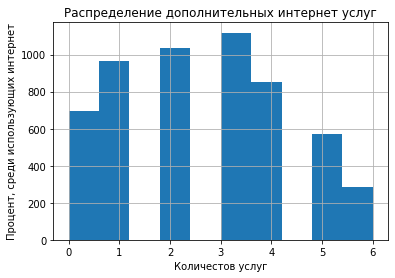

In [52]:
internet['sum'].hist()
plt.title('Распределение дополнительных интернет услуг')
plt.xlabel('Количестов услуг')
plt.ylabel('Процент, среди использующих интернет')

Из рапределения видно, что около 700 человек из 5517 не использует дополнительных услуг. В районе 300 человек используют все дополнительные услуги.



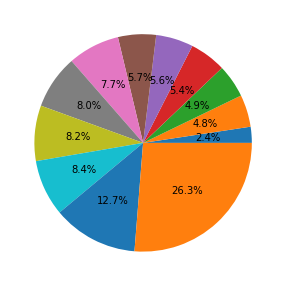

Type            PaymentMethod            
Two year        Electronic check              2.4%
One year        Mailed check                  4.8%
                Electronic check              4.9%
Two year        Mailed check                  5.4%
One year        Bank transfer (automatic)     5.6%
                Credit card (automatic)       5.7%
Month-to-month  Credit card (automatic)       7.7%
Two year        Bank transfer (automatic)     8.0%
                Credit card (automatic)       8.2%
Month-to-month  Bank transfer (automatic)     8.4%
                Mailed check                 12.7%
                Electronic check             26.3%
Name: PaymentMethod, dtype: object

In [53]:
plt.figure(figsize=(5,5))
payment_type = (contract.copy().groupby(['Type','PaymentMethod'])['PaymentMethod'].count()/ 7043).sort_values()
plt.pie(payment_type, autopct='%1.1f%%')
plt.show()
payment_type.map(lambda x: '{:.1%}'.format(x))

Из приведенного выше процентного распределения способов оплаты можно судить, что наиболее поппулярный формат - ежемесячное получение электронного чека. Более 26% всех абонентов пользуются им. 12.7% используют формат - ежемесячная плата с уведомление по почте. Далее примерно на одном уровне идут: ежемесячная автоматическая плата банковским переводом(8.4%), договор на два года с автоматической оплатой банковским переводом(8%), договор на два года с автоматической оплатой банковской картой(8.2%), ежемесячная автоматическая плата банковской картой(7.7%).

## План работ


1. Формирование признаков
    - Количество месяцев с заключения договора
    - Целевой признак - расторжение абанетом контракта
    - Определение оптимальных признаков для обучения модели и формирование из них обучающего датасета
2. Обучение модели
    - Подбор лучшей модели машинного обучения с метрикой ROC-AUC
3. Создание функций формирующих датасет для запрашиваемых данных. 

## Вопросы
- В каком формате предоставляются данные на проде об абонентах.
- Что обозначают признаки `Partner` и `Dependents`в датасете `personal`.

## Формирование признаков

Сформируем целевой признак.

In [54]:
contract['leave'] = contract['EndDate'].copy()
contract['leave'] = contract['leave'].replace('No', 0)
contract.loc[contract['leave']!=0, 'leave'] = 1

In [55]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,leave
0,7590-VHVEG,2020-01-01,No,Month-to-month,1,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,No,One year,0,Mailed check,56.95,1889.5,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,1,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,No,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,1,Electronic check,70.70,151.65,1


Сформируем признак - время действия договора. Эту информацию можно извлечь из столбцов `['BeginDate','EndDate']` таблицы `contract`. Заменим значение `'No'` в столбце `'EndDate'` на дату выгрузки базы. Привидем эти столбцы к формату даты.

In [56]:
contract['EndDate'] = contract['EndDate'].replace('No',pd.to_datetime('02-01-2020'))
contract['EndDate'] = pd.to_datetime(contract['EndDate'])

In [57]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,leave
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,1,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,0,Mailed check,56.95,1889.5,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,2020-02-01,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,1


Создадим функцию, вычисляющую количество месяцев, на которые был заключен договор.

In [58]:
def days_from_timedelta(timedelta):
    return round(int(str(timedelta).split(' ')[0]), 0)

def months_from_timedelta(timedelta):
    return round(int(str(timedelta).split(' ')[0]) / 30.5, 0)

Создадим признак `'timedelta_months'`

In [59]:
#contract['timedelta_days'] = (contract['EndDate'] - contract['BeginDate']).apply(days_from_timedelta)
contract['timedelta_months'] = (contract['EndDate'] - contract['BeginDate']).apply(months_from_timedelta)

Приведем все столбцы к нужному типу

In [60]:
contract = contract[contract['TotalCharges']!=' '].copy()

In [61]:
contract['TotalCharges'] = contract['TotalCharges'].astype('float')
contract['leave'] = contract['leave'].astype('int')

In [62]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 10 columns):
customerID          7032 non-null object
BeginDate           7032 non-null datetime64[ns]
EndDate             7032 non-null datetime64[ns]
Type                7032 non-null object
PaperlessBilling    7032 non-null int64
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float64
leave               7032 non-null int64
timedelta_months    7032 non-null float64
dtypes: datetime64[ns](2), float64(3), int64(2), object(3)
memory usage: 604.3+ KB


Для построения модели, получим приведем дамми признаки для переменных типа `object`

In [63]:
data = pd.get_dummies(contract,columns=['Type','PaymentMethod'],drop_first=True).drop(['BeginDate','EndDate'], axis=1)

In [64]:
data.head()

,customerID,PaperlessBilling,MonthlyCharges,TotalCharges,leave,timedelta_months,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,1,29.85,29.85,0,1.0,0,0,0,1,0
1,5575-GNVDE,0,56.95,1889.50,0,34.0,1,0,0,0,1
2,3668-QPYBK,1,53.85,108.15,1,2.0,0,0,0,0,1
3,7795-CFOCW,0,42.30,1840.75,0,45.0,1,0,0,0,0
4,9237-HQITU,1,70.70,151.65,1,2.0,0,0,0,1,0


In [65]:
internet = pd.get_dummies(internet,columns=['InternetService'],drop_first=True)

Объединим все таблицы и посмотрим, как коррелируют все призанки с целевым

In [78]:
def style_negative(v):
    return 'color:red' if v < 0 else 'color:black'

def style_main(v):
    return f'opacity: {np.abs(v*3)*100}%'

In [80]:
data.merge(internet,how='left')\
    .merge(phone,how='left')\
    .merge(personal,how='left').fillna(0).corr()[['leave']].sort_values(by='leave').T.style.applymap(style_negative).applymap(style_main)

,timedelta_months,Type_Two year,TotalCharges,Type_One year,OnlineSecurity,TechSupport,Dependents,Partner,PaymentMethod_Credit card (automatic),PaymentMethod_Mailed check,sum,OnlineBackup,DeviceProtection,isMale,MultipleLines,StreamingMovies,StreamingTV,SeniorCitizen,PaperlessBilling,MonthlyCharges,PaymentMethod_Electronic check,InternetService_Fiber optic,leave
leave,-0.354049,-0.301552,-0.199484,-0.178225,-0.17127,-0.164716,-0.163128,-0.149982,-0.134687,-0.0907728,-0.0878819,-0.082307,-0.0661925,-0.00854464,0.0400327,0.0608599,0.063254,0.150541,0.191454,0.192858,0.301455,0.307463,1


Корреляции для признака `'timedelta_months'`

In [81]:
data.merge(internet,how='left').merge(phone,how='left').merge(personal,how='left').fillna(0).corr(
)['timedelta_months'].sort_values().tail()

Partner             0.381912
sum                 0.495318
Type_Two year       0.563801
TotalCharges        0.825880
timedelta_months    1.000000
Name: timedelta_months, dtype: float64

Сильнее всего c целевым коррелирует признак `'timedelta_months'`, а также он мультиколлинеарен с `'TotalCharges'`. Из них нужно будет оставить тольк один. Посмотрим соотношение ушедших абонентов ко всем, в зависимости от времени

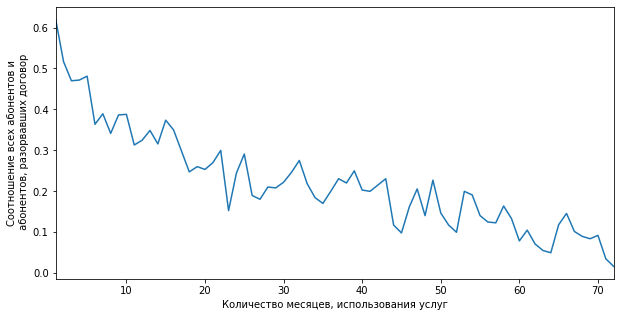

In [82]:
(data.groupby('timedelta_months')['leave'].sum() / data.groupby('timedelta_months')['leave'].count()).plot(figsize=(10,5))
plt.xlabel('Количество месяцев, использования услуг')
#plt.ylabel('Соотношение всех абонентов и абонентов, разорвавших договор')
plt.ylabel('Соотношение всех абонентов и\n абонентов, разорвавших договор')
plt.show()

In [83]:
(data.groupby('timedelta_months')['leave'].sum() / data.groupby('timedelta_months')['leave'].count()).head()

timedelta_months
1.0    0.619902
2.0    0.516807
3.0    0.470000
4.0    0.471591
5.0    0.481203
Name: leave, dtype: float64

Из графика видно, чем дольше абонент пользуется услугами, тем вероятнее, что он останется. Вероятность ухода абонента в первый месяц для нашей выборки составила 62%. Со временем вероятность медленно снижается почти до  0 


Создадим признаки для обучения модели. Из всех оставим только те, которые по модулю коррелируют более чем на 15%

In [84]:
features = data.merge(internet,how='left').merge(personal,how='left').fillna(0)\
    .drop(['customerID','leave'],
        axis=1)
target = data['leave'].fillna(0)

## Обучение модели

Разобьём выборку на тренировочную и тестовую

In [85]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345
)

Градиентный бустинг

In [86]:
cat_model = CatBoostClassifier(verbose=200, eval_metric='AUC',iterations=500,learning_rate=0.01, random_state=1234)
cat_model.fit(features_train,target_train,eval_set=(features_test, target_test))

0:	test: 0.8153099	best: 0.8153099 (0)	total: 52.1ms	remaining: 26s
200:	test: 0.8536811	best: 0.8536811 (200)	total: 5s	remaining: 7.45s
400:	test: 0.8553327	best: 0.8554225 (395)	total: 10s	remaining: 2.47s
499:	test: 0.8552628	best: 0.8554691 (424)	total: 12.5s	remaining: 0us

bestTest = 0.8554690683
bestIteration = 424

Shrink model to first 425 iterations.


In [87]:
print('roc_auc_score на тестовой выборке', roc_auc_score(target_test, cat_model.predict_proba(features_test)[:, 1]).round(3))
print('roc_auc_score на тренировочной выборке', roc_auc_score(target_train, cat_model.predict_proba(features_train)[:, 1]).round(3))

roc_auc_score на тестовой выборке 0.855
roc_auc_score на тренировочной выборке 0.874


Качество модели по метрике AUC-ROC составила 0.855 на тестовой выборке и 0.868 на тренировочной выборке. Значимости признаков, которые вывела модель

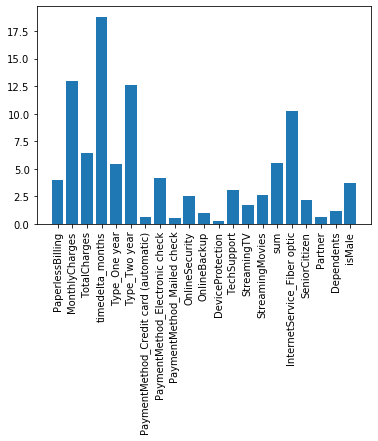

In [88]:
plt.bar(features.columns,cat_model.feature_importances_)
plt.xticks(rotation=90)
plt.show()

Оставим только значимые метрики

0:	test: 0.8274672	best: 0.8274672 (0)	total: 9.03ms	remaining: 9.02s
200:	test: 0.8545352	best: 0.8545751 (195)	total: 4.89s	remaining: 19.4s
400:	test: 0.8549410	best: 0.8552321 (315)	total: 9.6s	remaining: 14.3s
600:	test: 0.8542092	best: 0.8552321 (315)	total: 14.4s	remaining: 9.56s
800:	test: 0.8535522	best: 0.8552321 (315)	total: 19.2s	remaining: 4.76s
999:	test: 0.8522732	best: 0.8552321 (315)	total: 23.8s	remaining: 0us

bestTest = 0.8552320601
bestIteration = 315

Shrink model to first 316 iterations.


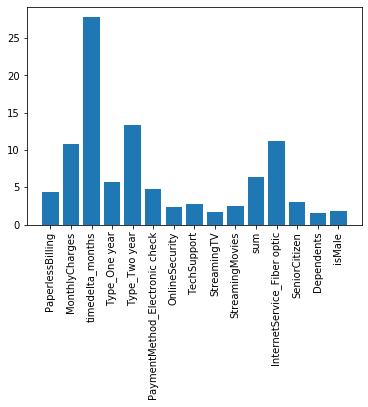

In [89]:
features = data.merge(internet,how='left').merge(personal,how='left').fillna(0)\
    .drop(['customerID','leave','PaymentMethod_Credit card (automatic)','OnlineBackup',
           'PaymentMethod_Mailed check','DeviceProtection','Partner','TotalCharges'],
        axis=1)
target = data['leave'].fillna(0)

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345
)

cat_model = CatBoostClassifier(verbose=200, eval_metric='AUC',iterations=1000,learning_rate=0.01, random_state=1234)
cat_model.fit(features_train,target_train,eval_set=(features_test, target_test))

plt.bar(features.columns,cat_model.feature_importances_)
plt.xticks(rotation=90)
plt.show()

Попробуем другие модели

Модель Логистической регрессии 

In [90]:
log_model = LogisticRegressionCV(cv=5, random_state=12345, max_iter=1000)
log_model.fit(features_train,target_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=1000, multi_class='warn', n_jobs=None,
                     penalty='l2', random_state=12345, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [91]:
print('roc_auc_score на тестовой выборке', roc_auc_score(target_test, log_model.predict_proba(features_test)[:, 1]).round(3))
print('roc_auc_score на тренировочной выборке', roc_auc_score(target_train, log_model.predict_proba(features_train)[:, 1]).round(3))

roc_auc_score на тестовой выборке 0.849
roc_auc_score на тренировочной выборке 0.837


Качество модели по метрике AUC-ROC составила 0.85 на тестовой выборке и 0.838 на тренировочной выборке

Модель случайного леса

In [92]:
forest_model = RandomForestClassifier(n_estimators=100,max_depth=6, random_state=12345)
forest_model.fit(features_train,target_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

In [93]:
print('roc_auc_score на тестовой выборке', roc_auc_score(target_test, forest_model.predict_proba(features_test)[:, 1]).round(3))
print('roc_auc_score на тренировочной выборке', roc_auc_score(target_train, forest_model.predict_proba(features_train)[:, 1]).round(3))

roc_auc_score на тестовой выборке 0.851
roc_auc_score на тренировочной выборке 0.868


Качество модели по метрике AUC-ROC составила 0.853 на тестовой выборке и 0.869 на тренировочной выборке

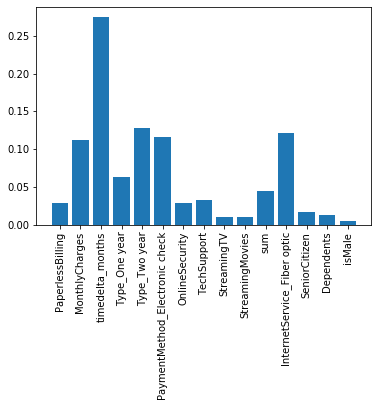

In [94]:
plt.bar(features.columns,forest_model.feature_importances_)
plt.xticks(rotation=90)
plt.show()

Лучше всего себя показала модель градиентного бустинга с качеством около 0.856 по метрике AUC-ROC. Остальные модели показали меньшее качество при небоьшом примуществе в скорости работы

## Создание .py файлов для прода.
Так как неизвестно, как именно будут отправляться файлы и в каком виде необходимо реализовать модель. Предположим, что есть возможность отправлять файлы в виде json. Реализацию сделаем на FastAPI.

```python
import os
import pandas as pd
import pickle
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
from preprocessing import preprocessing

app = FastAPI()

class StockIn(BaseModel):
    '''Модель, задающая тип входных '''
    phone : dict
    contract  : dict
    internet  : dict
    personal  : dict


class StockOut(BaseModel):
    '''Модель, задающая тип выходных данных'''
    predict: array


@app.post("/predict", response_model=StockOut, status_code=200)
def get_prediction(personal_data: StockIn):
    '''получение предсказания вероятности ухода абонента'''
    
    phone = pd.DataFrame(personal_data.phone)
    contract = pd.DataFrame(personal_data.contract)
    internet = pd.DataFrame(personal_data.internet)
    personal = pd.DataFrame(personal_data.personal)

    request = {}
    model = pickle.load(open(os.getcwd() +'/model.pkl','rb'))

    features = preprocessing(phone=phone, contract=contract, internet=internet, personal=personal)
    predict = model.predict_proba(features)

    return {'predict': predict}

```

Опустим описание функции `preprocessing` из `preprocessing.py`. Так как она должна содердать шаги по обработке данных и объединению таблиц, которые мы выполняли здесь ранее.

## ВЫВОДЫ

Проанализировав данные о 7043 абонентов, удалось построить модель градиентного бустинга CatBoost для задачи классификации, выявляющую возможный уход абонента с точностью по метрике AUC-ROC 0.855.

В результате анализа было выявлено, что абоненты в основном уходят на первых месяцах и чем дольше они пользуются услугами, тем менее вероятно, что они уйдут. Возможно стоит проработать программу удержания клиентов в первый год. Далее вероятность ухода устанавливается на уровне менее 30% постепенно снижаясь. 

На удивление, количество подключенных интернет услуг не оказало значимого воздействия на сохраняемость желание абонентов продолжать сотрудничества. Также не оказало влияние автоматическая оплата. Наоборот, абоненты, ежемесячно оплачивающие приходящие счета, остаются с большей вероятностью 

# Отчет
В плане было 3 пункта
1. Формирование признаков    
    В этом пункте были сформированы:
    - Количество месяцев с заключения договора
    - Целевой признак - расторжение абанетом контракта
    - Дамми признаки от строковых параметров (`['Type','InternetService','PaymentMethod']`)    

    Определение оптимальных признаков для обучения модели было перенесено в следующий пункт, так как было проведено на основе зависимостей найденных моделью градиентного бустинга CatBoost    


2. Обучение модели
Было обучено три вида моделей:
    - CatBoostClassifier (ROC-AUC=0.86)
    - LogisticRegressionCV (ROC-AUC=0.85)
    - RandomForestClassifier (ROC-AUC=0.85)

    Лучшей моделью машинного обучения с наибольшой метрикой ROC-AUC=0.86 была выбрана CatBoostClassifier. В качестве признак для обучения были выбраны:    
```python
        ['PaperlessBilling', 'MonthlyCharges', 'timedelta_months',
       'Type_One year', 'Type_Two year', 'PaymentMethod_Electronic check',
       'OnlineSecurity', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'sum', 'InternetService_Fiber optic', 'SeniorCitizen', 'Dependents',
       'isMale']
```
3. Создание функций формирующих датасет для запрашиваемых данных. 
    В этом пункте было решено создать интеграцию модели в виде API с помощью фреймворка FastAPI. Описание сторонних файлов для обеспечения корректной работы было опущено, так как подготовка данных была полностью проведена выше в этом файле.